# Index

1. [Packages](#packages)
2. [Data exploration](#data-exploration)
3. [Plots](#plots)
   
   3.1. [Correlation matrix](#correlation-matrix)

   3.2. [TOP CORRELATIONS BAR CHART](#top-correlations-bar-chart)

   3.3. [FRAUD DISTRIBUTION](#fraud-distribution) 

    3.3.0. [BOXPLOTS BY FRAUD STATUS](#boxplots-by-fraud-status)

    3.3.1. [FRAUD RATE BY CATEGORICAL VARIABLES](#fraud-rate-by-categorical-variables)

    3.3.2. [FRAUD RATE BY BINARY VARIABLES](#fraud-rate-by-binary-variables)

    3.3.3. [TIME-BASED ANALYSIS](#time-based-analysis)

    3.3.4. [DISTRIBUTION OF KEY VARIABLES](#distribution-of-key-variables)

4. [Outliers](#outliers)
5. [Dashboard](#dashboard)

# Packages

In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.abspath(".."))

from mlparadetectarfraudes.data import data
 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pointbiserialr, chi2_contingency




# Data exploration

In [2]:
figures_path = Path('../reports/figures/')
figures_path.mkdir(parents=True, exist_ok=True)

In [4]:
data
data.sort_values(["transaction_datetime"], ascending=False)

,transaction_datetime,amount,user_age,user_income,device_type,os_type,browser,country,city_size,num_products,...,transaction_day,transaction_month,is_night,is_weekend,is_fraud,amount_to_income_ratio,avg_product_price,high_value_transaction,new_customer,unusual_device_combo
48372,2023-12-30,67.809160,62,74577,tablet,iOS,Chrome,ARS,Suburban,2,...,5,12,1,1,0,0.010911,33.904580,0,0,0
47241,2023-12-30,196.518864,42,51686,mobile,Android,Firefox,BR,Metro,1,...,5,12,1,1,0,0.045626,196.518864,0,0,0
8781,2023-12-30,93.974786,59,50966,mobile,iOS,Chrome,US,Metro,3,...,5,12,1,1,0,0.022126,31.324929,0,0,0
37436,2023-12-30,71.402972,18,64386,desktop,Android,Chrome,BR,Metro,2,...,5,12,1,1,0,0.013308,35.701486,0,0,0
5880,2023-12-30,62.040551,74,63092,desktop,Windows,Safari,UK,Metro,3,...,5,12,1,1,0,0.011800,20.680184,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44246,2023-01-01,337.298650,35,39723,mobile,Windows,Edge,US,Suburban,2,...,6,1,1,1,0,0.101895,168.649325,0,0,1
23071,2023-01-01,72.158779,51,26936,mobile,Android,Firefox,MX,Metro,4,...,6,1,1,1,0,0.032147,18.039695,0,0,0
37578,2023-01-01,9.594605,18,54644,mobile,Windows,Safari,UK,Urban,2,...,6,1,1,1,0,0.002107,4.797303,0,0,1
8476,2023-01-01,93.481461,31,42431,mobile,MacOS,Firefox,UK,Urban,2,...,6,1,1,1,0,0.026438,46.740730,0,0,0


In [6]:

#Verifiquemos si tenemos como estructura de dato un dataframe!
print(type(data))
#Conocer informacion basica
print('Cantidad de Filas y columnas:',data.shape)
print('Nombre columnas:',data.columns)



<class 'pandas.core.frame.DataFrame'>
Cantidad de Filas y columnas: (50000, 25)
Nombre columnas: Index(['transaction_datetime', 'amount', 'user_age', 'user_income',
       'device_type', 'os_type', 'browser', 'country', 'city_size',
       'num_products', 'repeat_customer', 'account_age_days',
       'previous_chargebacks', 'is_dead_user', 'transaction_hour',
       'transaction_day', 'transaction_month', 'is_night', 'is_weekend',
       'is_fraud', 'amount_to_income_ratio', 'avg_product_price',
       'high_value_transaction', 'new_customer', 'unusual_device_combo'],
      dtype='object')


In [9]:
#Tipos de datos

print(data.dtypes)

transaction_datetime      datetime64[ns]
amount                           float64
user_age                           int32
user_income                        int64
device_type                       object
os_type                           object
browser                           object
country                           object
city_size                         object
num_products                       int32
repeat_customer                    int64
account_age_days                   int32
previous_chargebacks               int32
is_dead_user                       int64
transaction_hour                   int32
transaction_day                    int32
transaction_month                  int32
is_night                           int64
is_weekend                         int64
is_fraud                           int32
amount_to_income_ratio           float64
avg_product_price                float64
high_value_transaction             int64
new_customer                       int64
unusual_device_c

In [58]:
# 1. SEPARATE VARIABLE TYPES
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
binary_cols = [col for col in numeric_cols if data[col].nunique() == 2 and col != 'is_fraud']
numeric_cols = [col for col in numeric_cols if col not in binary_cols and col != 'transaction_datetime']

print("Numerical columns:")
print(numeric_cols)
print("Categorical columns:")
print(categorical_cols)
print("Binary columns:")
print(binary_cols)

Numerical columns:
['amount', 'user_age', 'user_income', 'num_products', 'account_age_days', 'previous_chargebacks', 'transaction_hour', 'transaction_day', 'transaction_month', 'is_night', 'is_fraud', 'amount_to_income_ratio', 'avg_product_price', 'new_customer']
Categorical columns:
['device_type', 'os_type', 'browser', 'country', 'city_size']
Binary columns:
['repeat_customer', 'is_dead_user', 'is_weekend', 'high_value_transaction', 'unusual_device_combo']


In [54]:
data[numeric_cols].describe().round(2)

,amount,user_age,user_income,num_products,repeat_customer,account_age_days,previous_chargebacks,is_dead_user,transaction_hour,transaction_day,transaction_month,is_night,is_weekend,is_fraud,amount_to_income_ratio,avg_product_price,high_value_transaction,new_customer,unusual_device_combo
count,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.0,50000.00,50000.00,50000.0,50000.00,50000.00,50000.00,50000.00,50000.00,50000.0,50000.00
mean,140.97,45.82,50038.16,3.00,0.70,365.00,0.10,0.00,0.0,3.01,6.48,1.0,0.29,0.04,0.04,60.35,0.07,0.0,0.15
std,295.23,16.45,14998.38,1.41,0.46,19.08,0.31,0.01,0.0,2.00,3.45,0.0,0.45,0.18,0.11,147.22,0.26,0.0,0.36
min,0.00,18.00,-9989.00,1.00,0.00,272.00,0.00,0.00,0.0,0.00,1.00,1.0,0.00,0.00,-8.40,0.00,0.00,0.0,0.00
25%,18.38,32.00,39960.00,2.00,0.00,352.00,0.00,0.00,0.0,1.00,3.00,1.0,0.00,0.00,0.00,6.31,0.00,0.0,0.00
50%,46.32,46.00,50021.50,3.00,1.00,365.00,0.00,0.00,0.0,3.00,6.00,1.0,0.00,0.00,0.01,17.26,0.00,0.0,0.00
75%,111.27,60.00,60121.50,4.00,1.00,378.00,0.00,0.00,0.0,5.00,9.00,1.0,1.00,0.00,0.03,45.55,0.00,0.0,0.00
max,4459.09,74.00,113030.00,12.00,1.00,445.00,3.00,1.00,0.0,6.00,12.00,1.0,1.00,1.00,7.03,4411.86,1.00,0.0,1.00


In [62]:
# El promedio de las variables binarias es la proporción que representan
binary_props = data[binary_cols].mean() * 100
for col, prop in binary_props.items():
    print(f"Proporción de la variable '{col}': {prop:.2f}%")

Proporción de la variable 'repeat_customer': 70.16%
Proporción de la variable 'is_dead_user': 0.02%
Proporción de la variable 'is_weekend': 28.88%
Proporción de la variable 'high_value_transaction': 7.40%
Proporción de la variable 'unusual_device_combo': 15.05%


In [12]:
# Mostrar solo columnas con valores nulos
null_counts = data.isnull().sum()
null_columns = null_counts[null_counts > 0]

if not null_columns.empty:
    print("Columnas con valores nulos:")
    print(null_columns)
else:
    print("No hay valores nulos en el DataFrame.")



No hay valores nulos en el DataFrame.


In [14]:
# cantidad de unicos
print('Cantidad de valores unicos por columna:\n',data.nunique().sort_values())

Cantidad de valores unicos por columna:
 is_night                      1
transaction_hour              1
new_customer                  1
unusual_device_combo          2
high_value_transaction        2
is_fraud                      2
is_weekend                    2
is_dead_user                  2
repeat_customer               2
device_type                   3
previous_chargebacks          4
city_size                     4
browser                       4
os_type                       4
country                       5
transaction_day               7
transaction_month            12
num_products                 12
user_age                     57
account_age_days            150
transaction_datetime        364
user_income               33038
amount_to_income_ratio    50000
avg_product_price         50000
amount                    50000
dtype: int64
                          count                        mean  \
transaction_datetime      50000  2023-06-30 13:45:36.576000   
amount              

In [16]:
# Sumar todos los valores de la columna 'is_fraud'
suma_total_fraudes = data['is_fraud'].sum()
# Agrupar por país y sumar el número de fraudes en cada pais
fraude_x_pais = data.groupby(['country']).agg({'is_fraud': 'sum'}).reset_index()
# Utiliza el método rename para cambiar el nombre de la columna
#data.rename(columns={'user_age': 'user_age'}, inplace=True)


In [ ]:
# Sumar el valor de amount para registros con is_fraud == 1
total_fraude_amount = data.loc[data['is_fraud'] == 1, 'amount'].sum()
print(f"Monto total perdido por fraudes: ${total_fraude_amount:,.2f}")

Monto total de amount para fraudes: $358,585.38


# Plots

In [ ]:
# Create directory if it doesn't exist
figures_path = Path('../reports/figures/')
figures_path.mkdir(parents=True, exist_ok=True)

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

# 1. SEPARATE VARIABLE TYPES
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
binary_cols = [col for col in numeric_cols if data[col].nunique() == 2 and col != 'is_fraud']
numeric_cols = [col for col in numeric_cols if col not in ['transaction_datetime']]

Numerical columns:
['amount', 'user_age', 'user_income', 'num_products', 'repeat_customer', 'account_age_days', 'previous_chargebacks', 'is_dead_user', 'transaction_hour', 'transaction_day', 'transaction_month', 'is_night', 'is_weekend', 'is_fraud', 'amount_to_income_ratio', 'avg_product_price', 'high_value_transaction', 'new_customer', 'unusual_device_combo']
Categorical columns:
['device_type', 'os_type', 'browser', 'country', 'city_size']
Binary columns:
['repeat_customer', 'is_dead_user', 'is_weekend', 'high_value_transaction', 'unusual_device_combo']


## Correlation matrix

c:\Users\agust\miniconda3\envs\mlparadetectarfraudes\Lib\site-packages\scipy\stats\_stats_py.py:5534: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


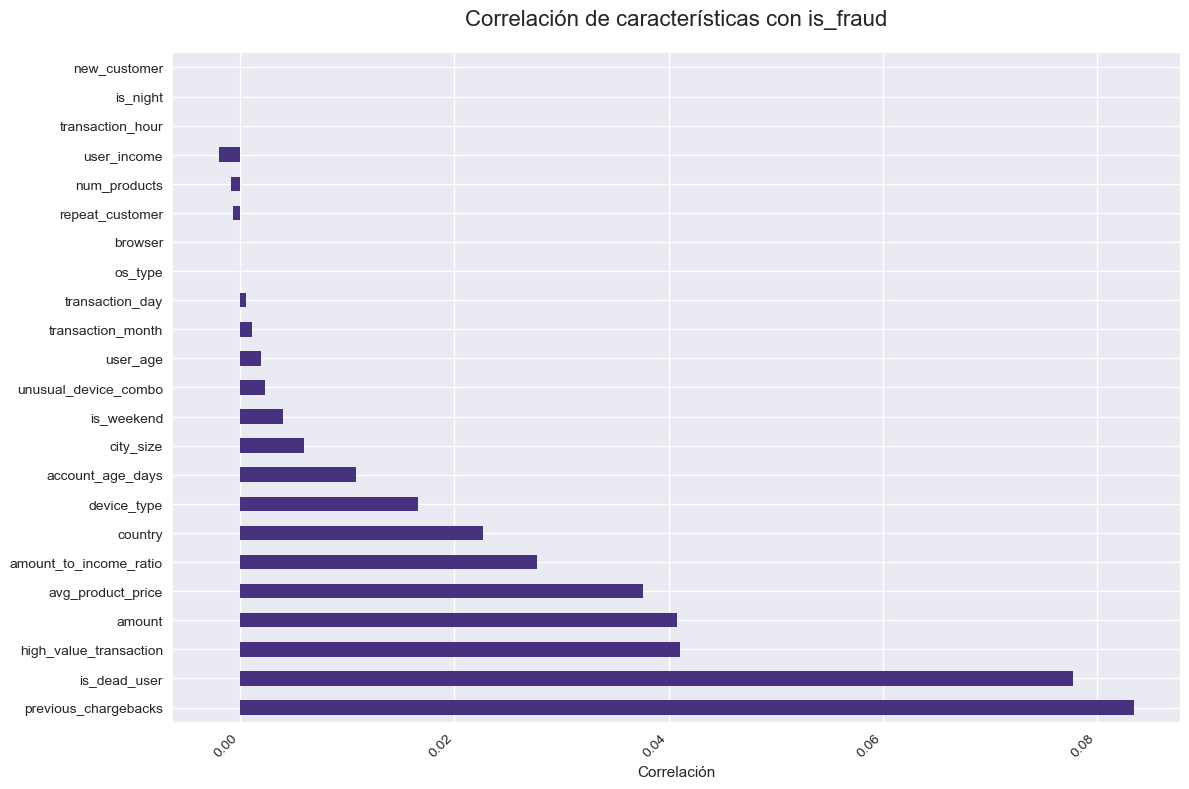

In [20]:
# Cargar tus datos (ya los tienes generados)
df = data.copy()

figures_path = Path('../reports/figures/')
figures_path.mkdir(parents=True, exist_ok=True)


from mlparadetectarfraudes.visualization import calculate_correlations

# Calcular y visualizar correlaciones
correlations = calculate_correlations(df)
plt.figure(figsize=(12, 8))
correlations.plot(kind='barh')
plt.title('Correlación de características con is_fraud', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Correlación')
plt.tight_layout()
plt.show()

## TOP CORRELATIONS BAR CHART

In [25]:
correlations.head(10)

previous_chargebacks      0.083485
is_dead_user              0.077730
high_value_transaction    0.041090
amount                    0.040803
avg_product_price         0.037606
amount_to_income_ratio    0.027685
country                   0.022669
device_type               0.016591
account_age_days          0.010846
city_size                 0.006005
dtype: float64

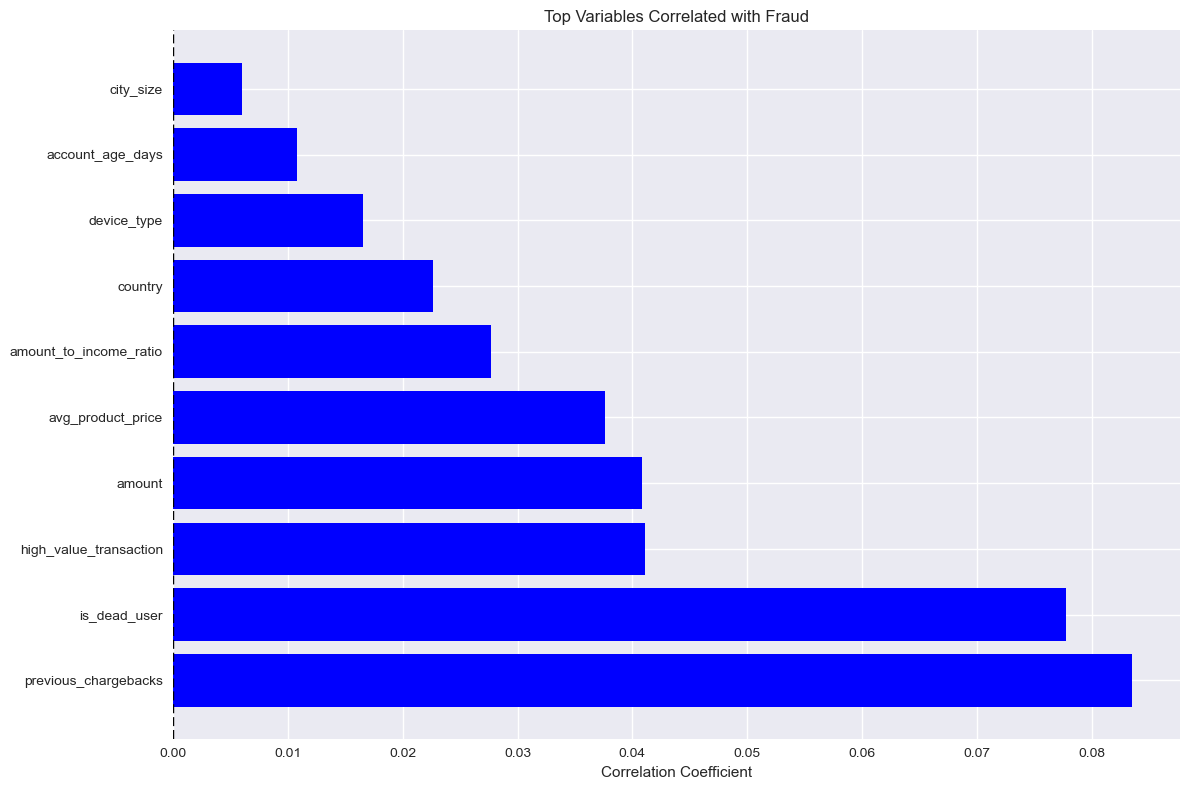

In [27]:
#. TOP CORRELATIONS BAR CHART
plt.figure(figsize=(12, 8))
top_vars = correlations.head(10)
colors = ['red' if x < 0 else 'blue' for x in top_vars.values]

plt.barh(top_vars.index, top_vars.values, color=colors)
plt.xlabel('Correlation Coefficient')
plt.title('Top Variables Correlated with Fraud')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.savefig(figures_path / 'top_correlations.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'top_correlations.pdf', bbox_inches='tight')
plt.show()

## FRAUD DISTRIBUTION

Distribución de fraudes:
is_fraud
0    48243
1     1757
Name: count, dtype: int64
Porcentaje de fraudes: 3.51%


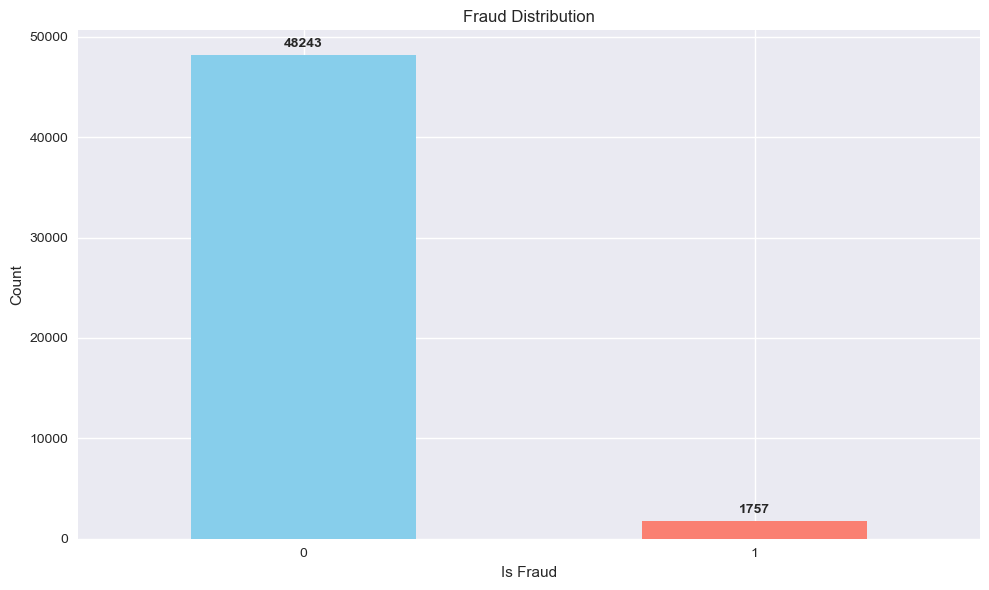

In [29]:
# Ver distribución de la variable objetivo
print("Distribución de fraudes:")
print(df['is_fraud'].value_counts())
print(f"Porcentaje de fraudes: {df['is_fraud'].mean()*100:.2f}%")

#. FRAUD DISTRIBUTION
plt.figure(figsize=(10, 6))
ax = data['is_fraud'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Fraud Distribution')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.xticks(rotation=0)
# Annotate each bar with its value
for i, v in enumerate(data['is_fraud'].value_counts()):
    ax.text(i, v + max(data['is_fraud'].value_counts()) * 0.01, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.savefig(figures_path / 'fraud_distribution.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'fraud_distribution.pdf', bbox_inches='tight')
plt.show()

### BOXPLOTS BY FRAUD STATUS

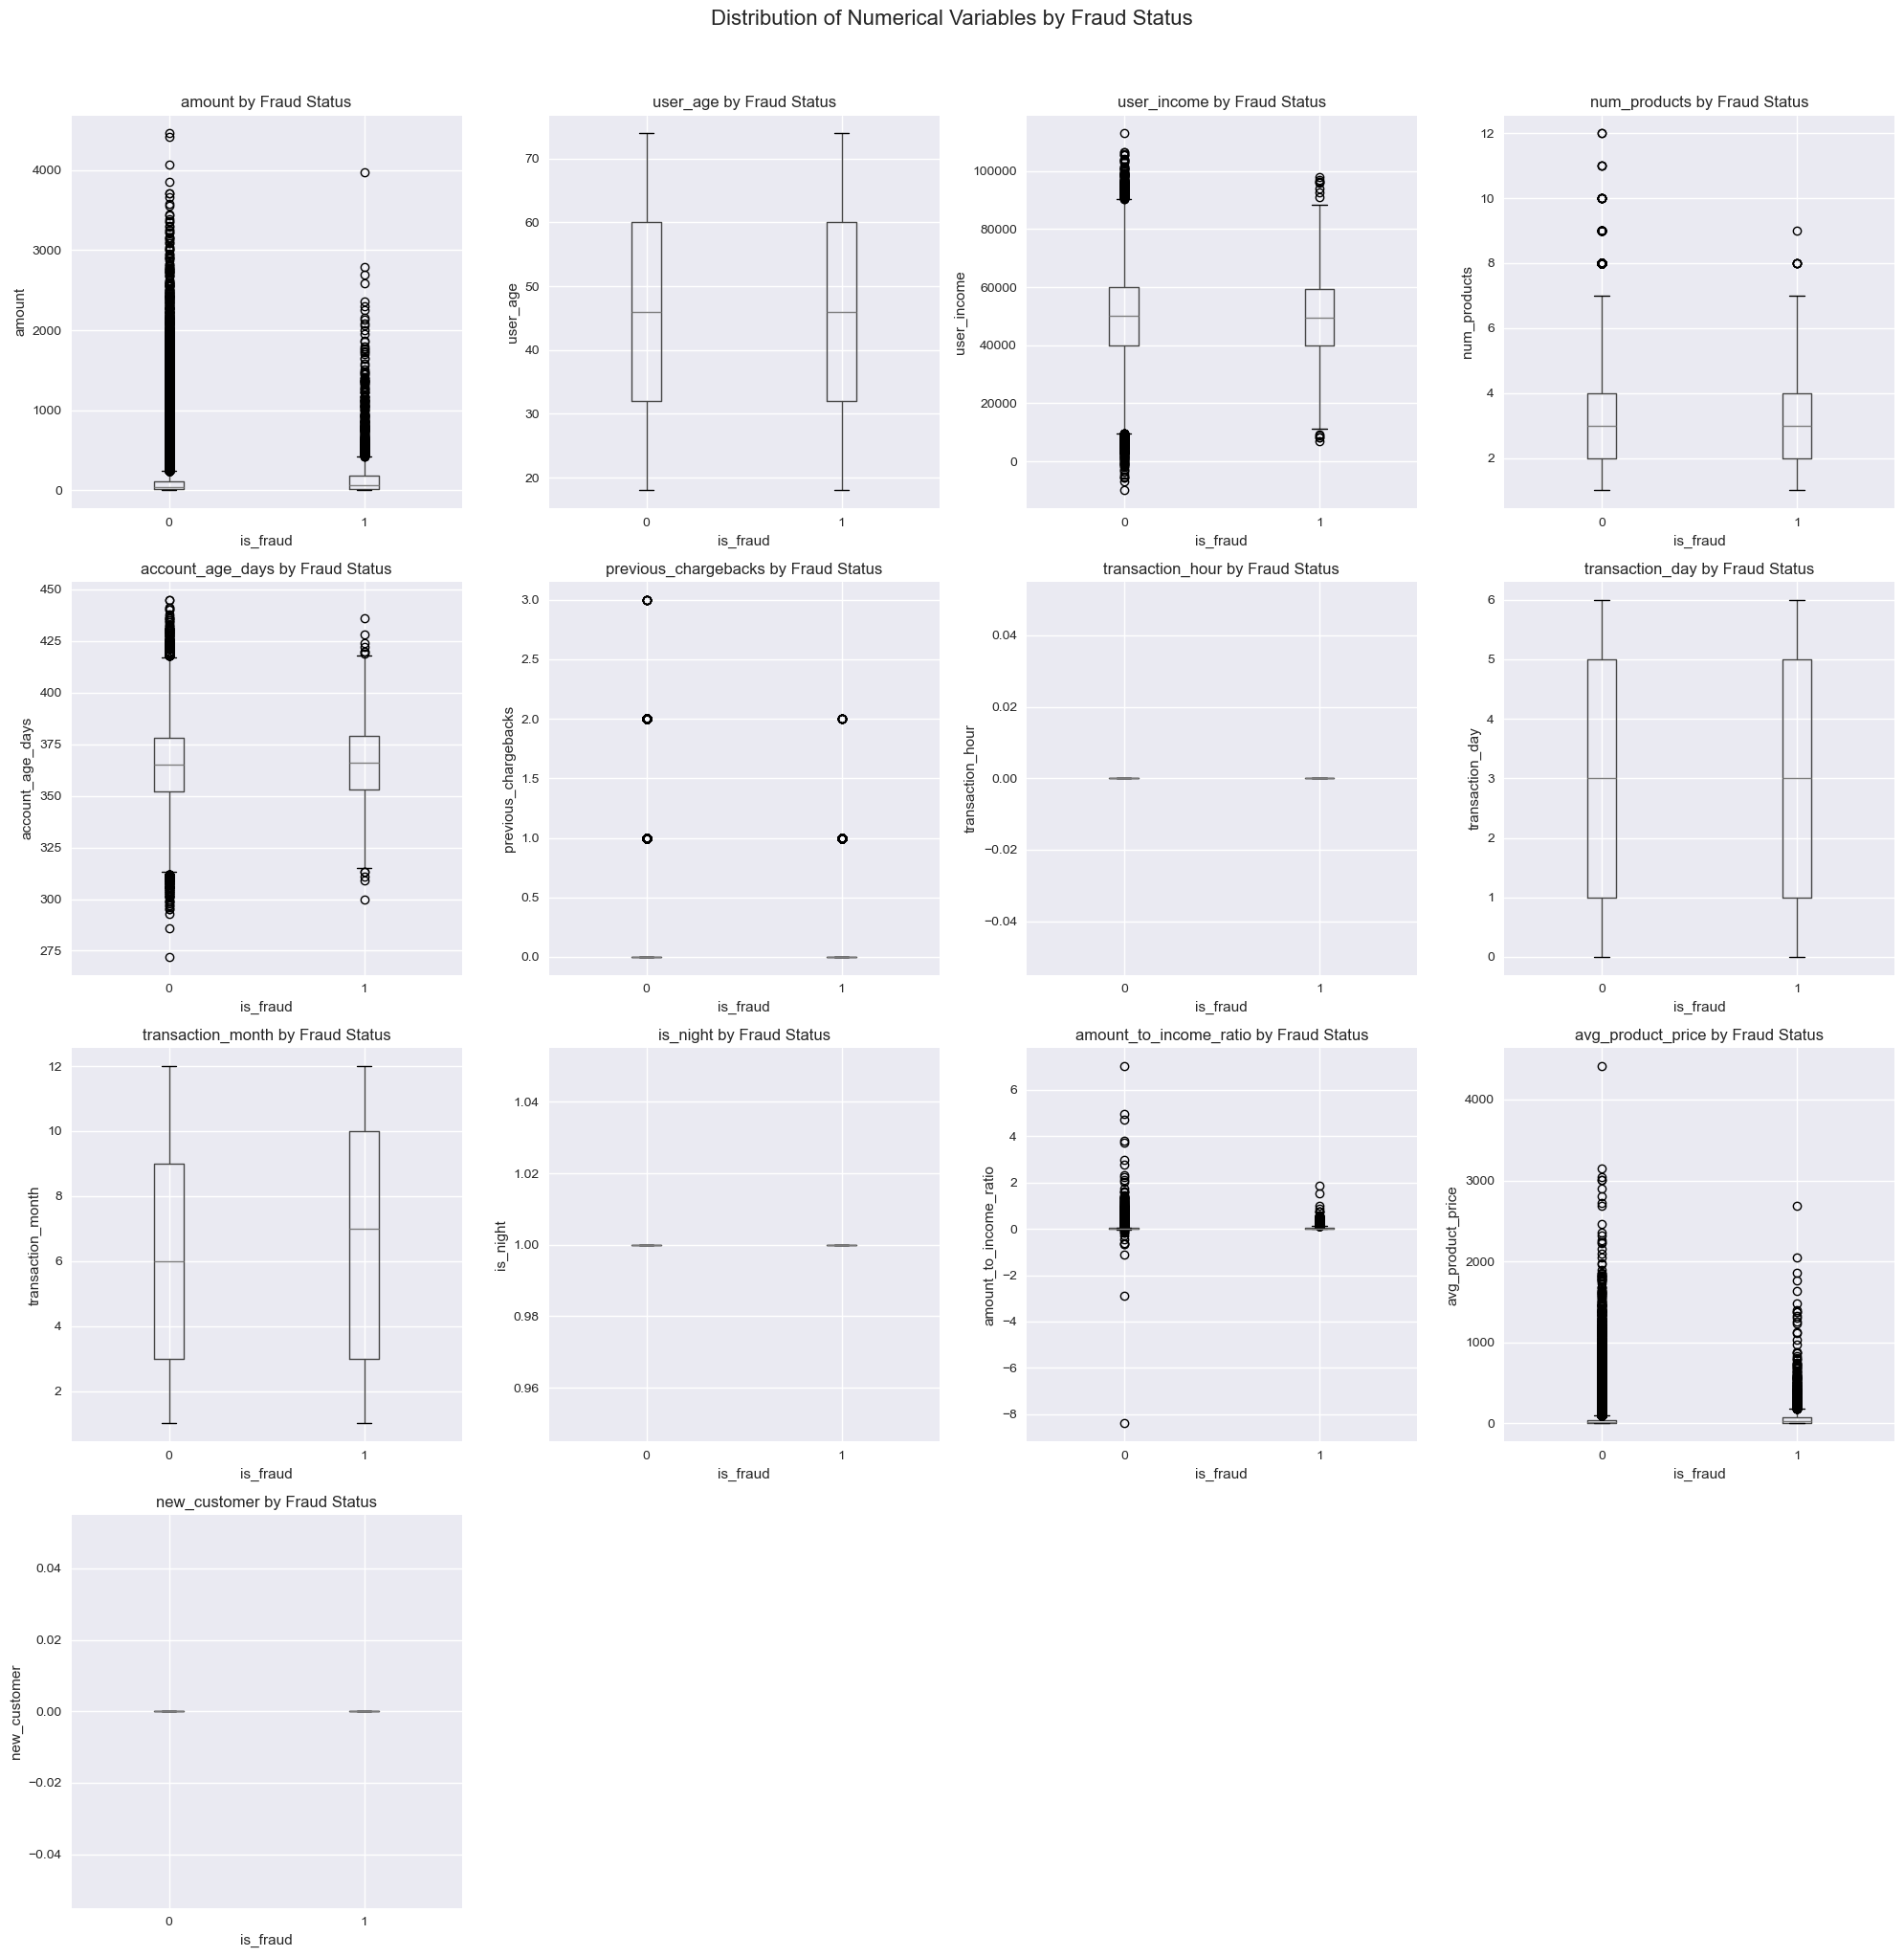

In [32]:
#. BOXPLOTS BY FRAUD STATUS
true_numeric = [col for col in numeric_cols if col not in binary_cols + ['is_fraud']]
n_cols = 4
n_rows = (len(true_numeric) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(true_numeric):
    data.boxplot(column=col, by='is_fraud', ax=axes[i])
    axes[i].set_title(f'{col} by Fraud Status')
    axes[i].set_ylabel(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribution of Numerical Variables by Fraud Status', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(figures_path / 'boxplots_by_fraud.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'boxplots_by_fraud.pdf', bbox_inches='tight')
plt.show()

### FRAUD RATE BY CATEGORICAL VARIABLES

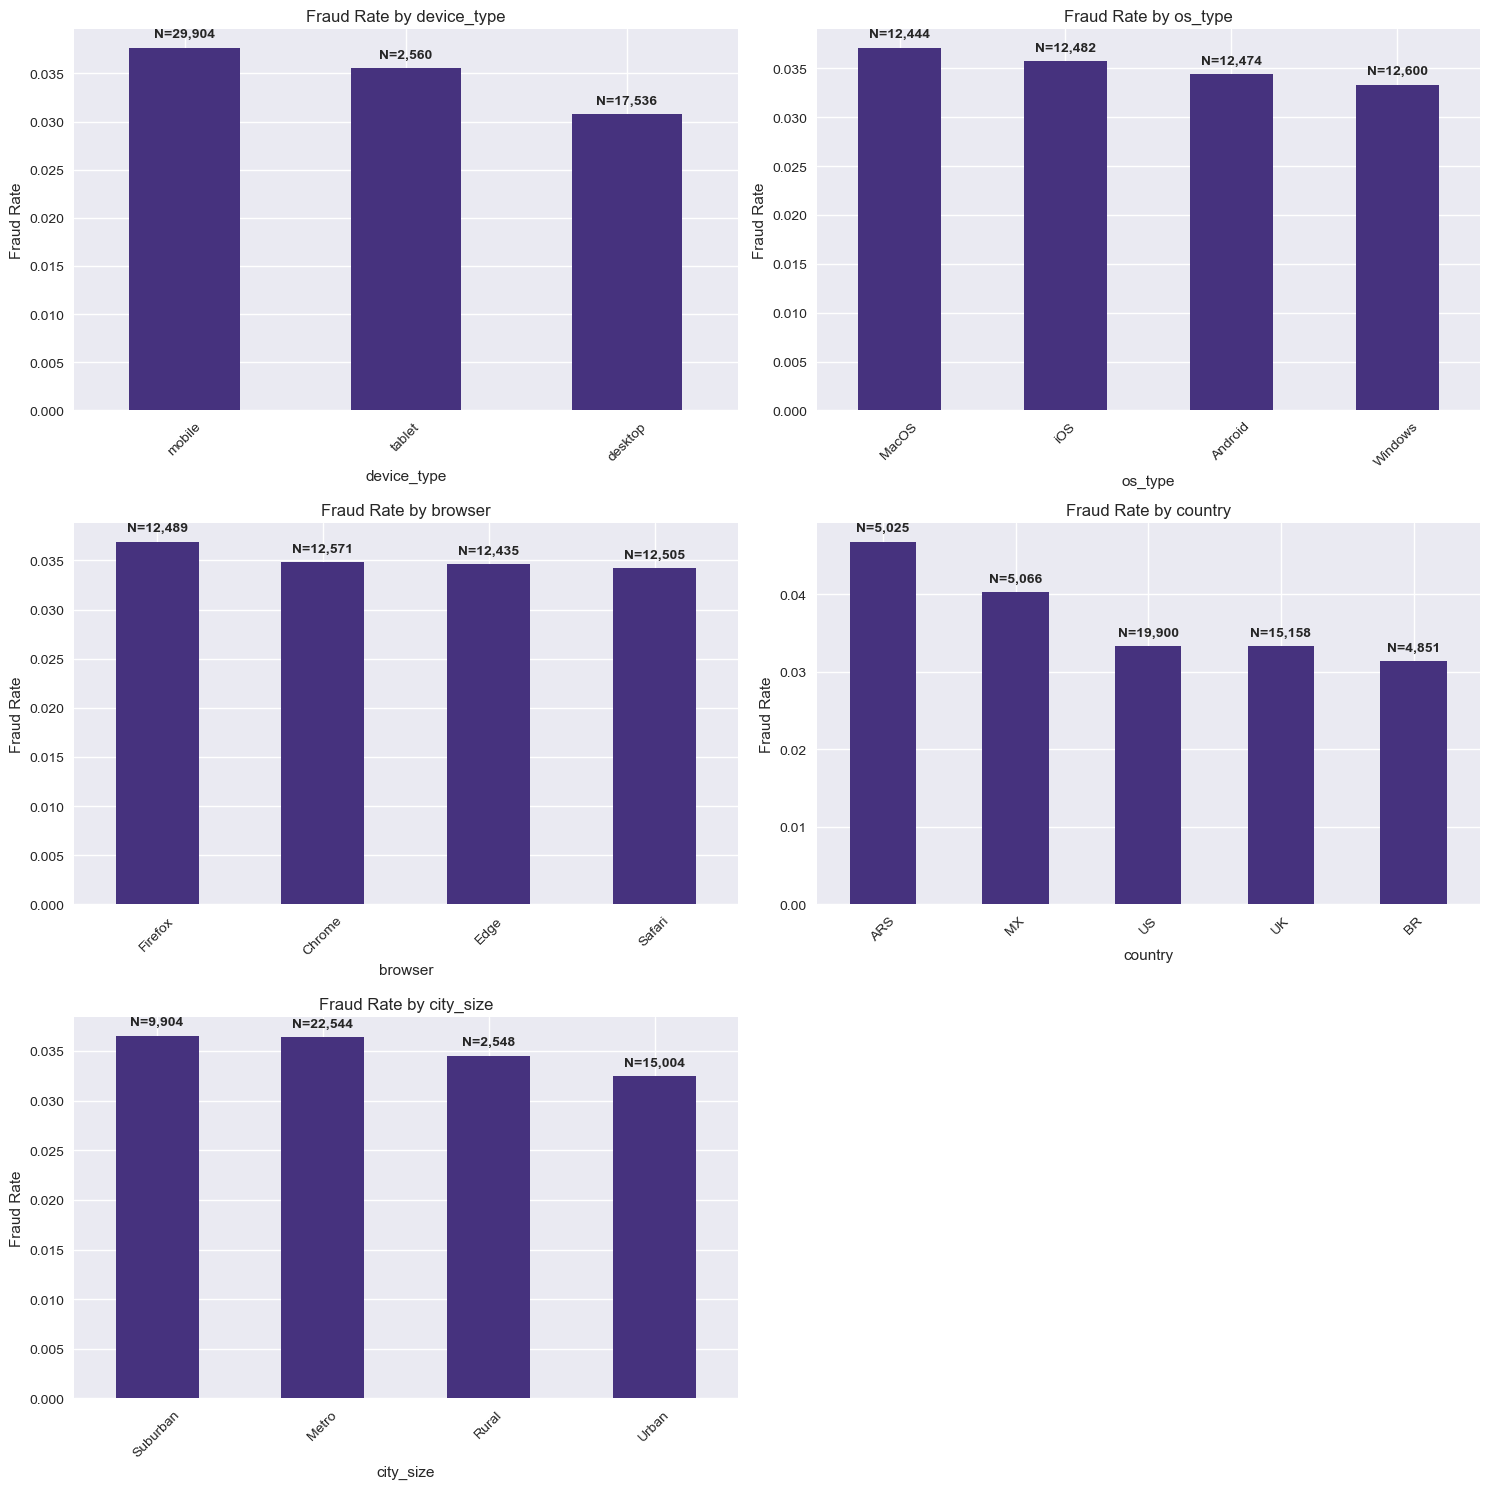

In [42]:
#. FRAUD RATE BY CATEGORICAL VARIABLES
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
n_cats = len(categorical_cols)
n_cols = 2
n_rows = (n_cats + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    fraud_rates = data.groupby(col)['is_fraud'].mean().sort_values(ascending=False).head(8)
    counts = data[col].value_counts()
    ax = fraud_rates.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Fraud Rate by {col}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel('Fraud Rate')
    # Add count labels above bars with thousands separator
    ymax = fraud_rates.max()
    for idx, value in enumerate(fraud_rates.index):
        axes[i].text(
            idx,
            fraud_rates[value] + ymax * 0.02,  # 2% above the highest bar
            f'N={counts[value]:,}',
            ha='center',
            va='bottom',
            fontweight='bold'
        )

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(figures_path / 'fraud_rate_categorical.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'fraud_rate_categorical.pdf', bbox_inches='tight')
plt.show()

### FRAUD RATE BY BINARY COLUMNS

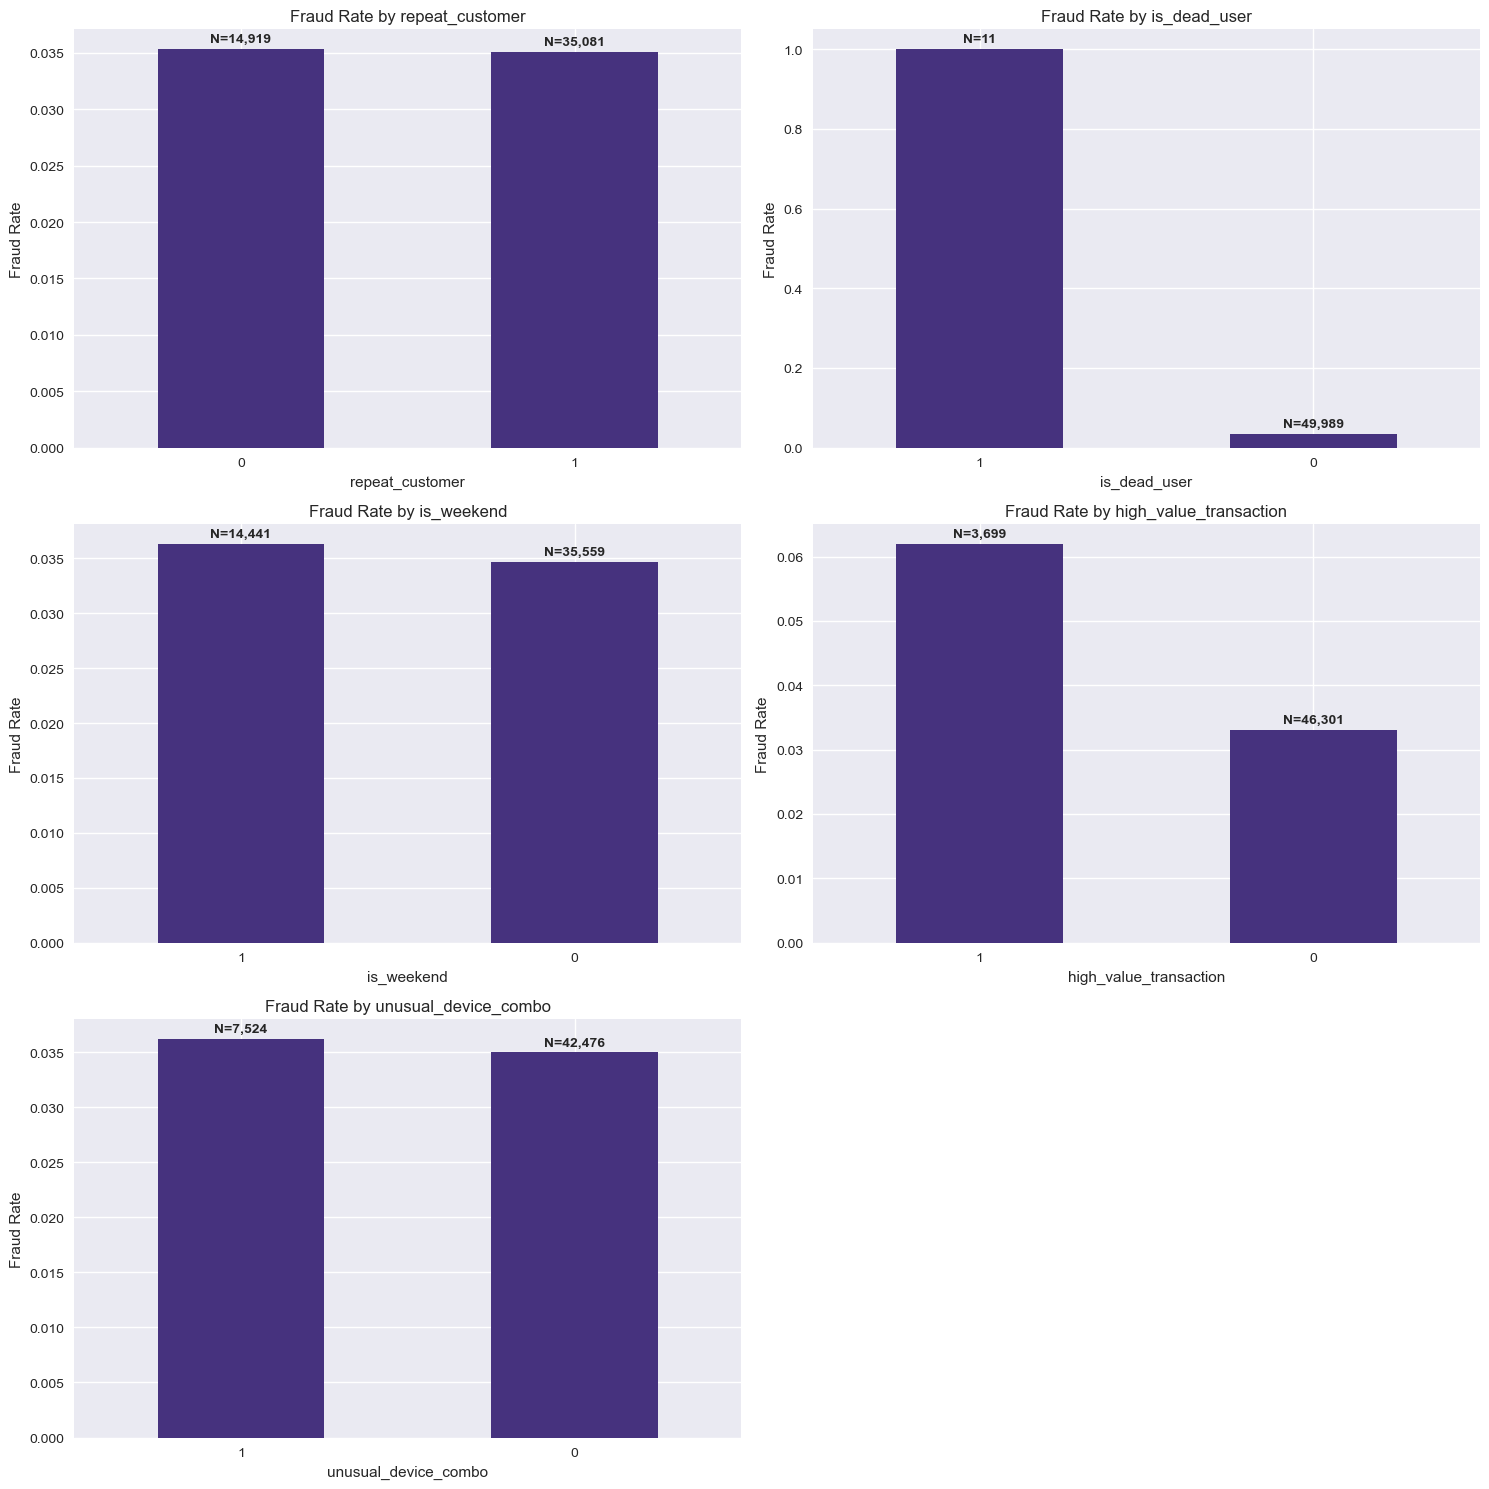

In [48]:
#. FRAUD RATE BY BINARY VARIABLES
binary_cols = [col for col in numeric_cols if data[col].nunique() == 2 and col != 'is_fraud']
n_cats = len(binary_cols)
n_cols = 2
n_rows = (n_cats + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(binary_cols):
    fraud_rates = data.groupby(col)['is_fraud'].mean().sort_values(ascending=False).head(8)
    counts = data[col].value_counts()
    ax = fraud_rates.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Fraud Rate by {col}')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].set_ylabel('Fraud Rate')
    # Etiquetas con cantidad de datos
    for idx, value in enumerate(fraud_rates.index):
        y = fraud_rates[value]
        ymax = fraud_rates.max()
        axes[i].text(
            idx, 
            y + ymax * 0.01,  # 1% arriba de la barra más alta
            f'N={counts[value]:,}', 
            ha='center', 
            va='bottom', 
            fontweight='bold'
        )

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(figures_path / 'fraud_rate_binary.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'fraud_rate_binary.pdf', bbox_inches='tight')
plt.show()

### TIME-BASED ANALYSIS

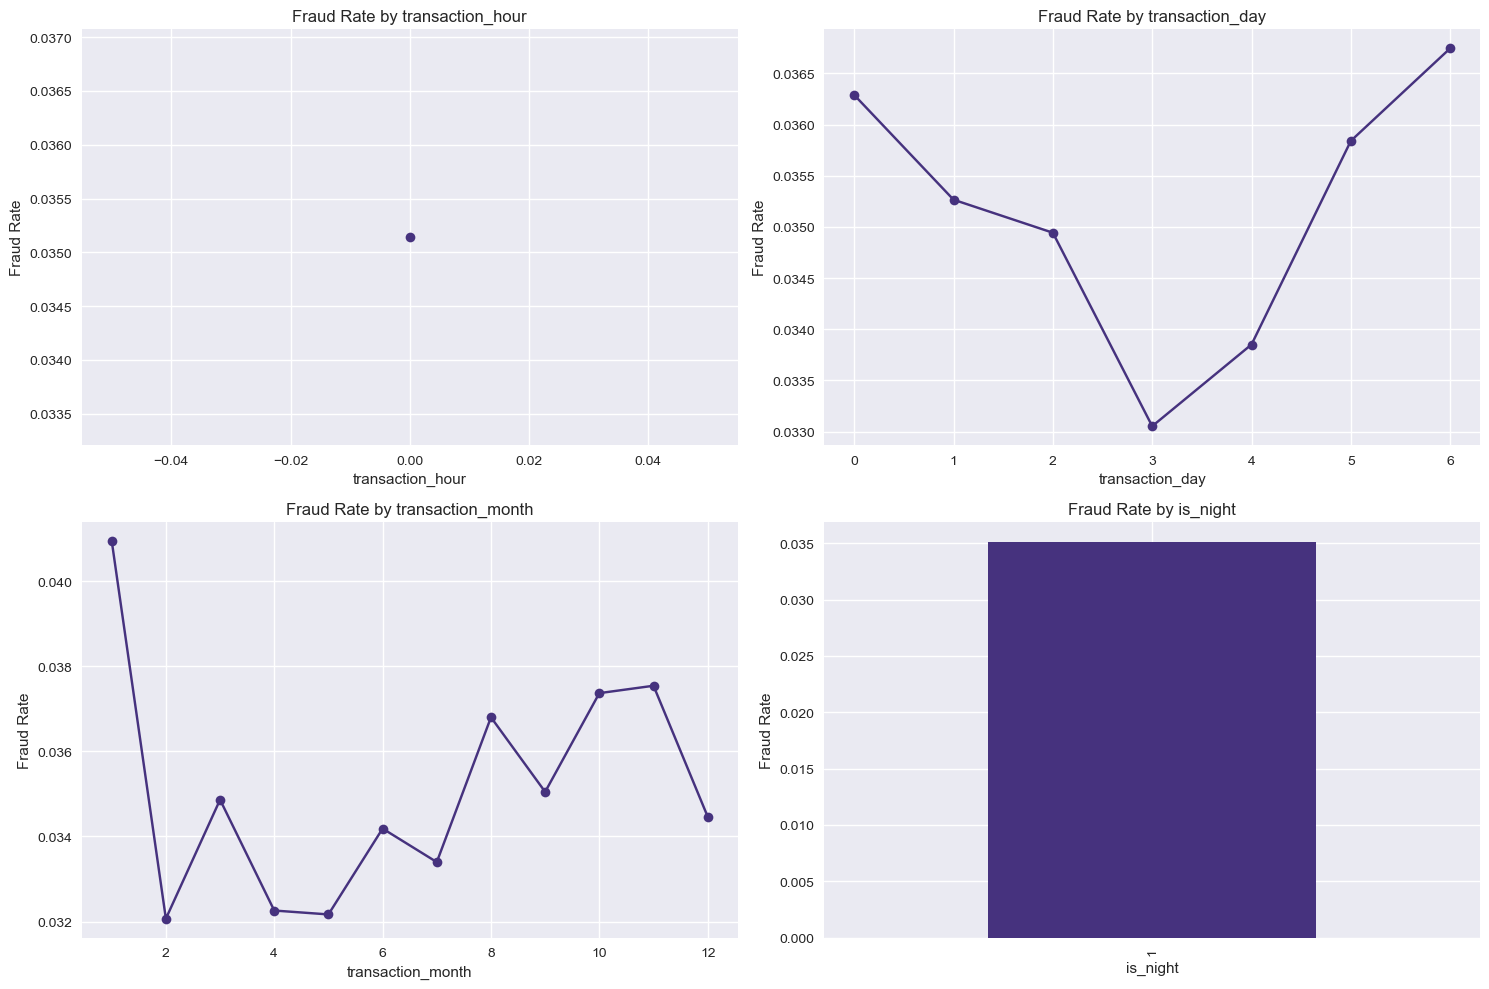

In [44]:
#. TIME-BASED ANALYSIS 
time_vars = ['transaction_hour', 'transaction_day', 'transaction_month', 'is_night']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(time_vars):
    fraud_by_time = data.groupby(col)['is_fraud'].mean()
    
    if col != 'is_night':
        # For continuous time variables
        fraud_by_time.plot(kind='line', ax=axes[i], marker='o', linestyle='-')
    else:
        # For binary variable
        fraud_by_time.plot(kind='bar', ax=axes[i])
    
    axes[i].set_title(f'Fraud Rate by {col}')
    axes[i].set_ylabel('Fraud Rate')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.savefig(figures_path / 'fraud_rate_time.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'fraud_rate_time.pdf', bbox_inches='tight')
plt.show()



### DISTRIBUTION OF KEY VARIABLES

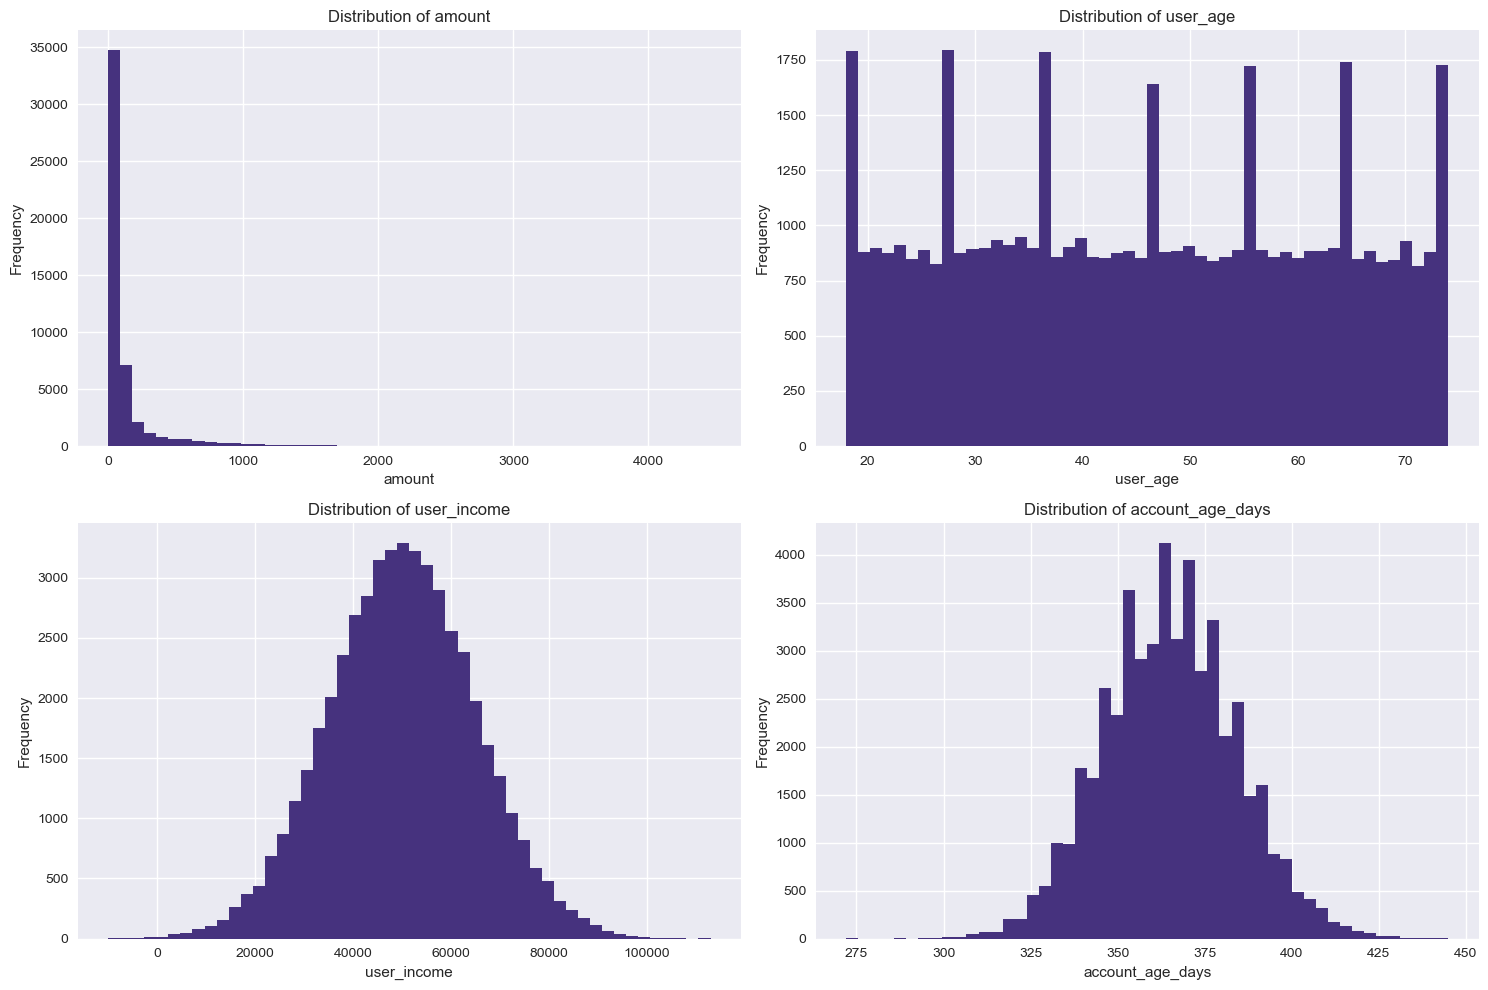

All plots saved to: c:\Users\agust\OneDrive\Documentos\VScode\Fraudes\mlparadetectarfraudes\notebooks\..\reports\figures


In [49]:
#. DISTRIBUTION OF KEY VARIABLES
key_vars = ['amount', 'user_age', 'user_income', 'account_age_days']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(key_vars):
    data[var].hist(bins=50, ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(figures_path / 'key_variables_distribution.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path / 'key_variables_distribution.pdf', bbox_inches='tight')
plt.show()

print(f"All plots saved to: {figures_path.absolute()}")

# Outliers

In [52]:
# Detection of outlier values using the interquartile range.

for column in data.select_dtypes(include = "number"):
    Q1 = stats[column]['25%']
    Q3 = stats[column]['75%']
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    outliers = data.loc[(data[column] < lower_limit) | (data[column] > upper_limit)]
    
    print(f"Column: {column}")
    print(outliers)
    print("------------------------")

Column: amount
      transaction_datetime      amount  user_age  user_income device_type  \
151             2023-01-13  287.222742        19        45722      mobile   
548             2023-08-12  262.940467        65        40557      mobile   
574             2023-12-05  326.506024        70        51256      mobile   
732             2023-06-26  343.759923        37        41289     desktop   
734             2023-04-15  264.483951        37        51322      mobile   
...                    ...         ...       ...          ...         ...   
49993           2023-03-05  640.235502        66        55530      mobile   
49995           2023-06-22  408.724665        38        49025      mobile   
49996           2023-09-14  966.500844        48        36805     desktop   
49997           2023-07-22  962.866695        69        30910      mobile   
49999           2023-04-13  256.346656        67        34511     desktop   

       os_type  browser country city_size  num_products  ...

# Dashboard
Todavía no disponibles

## Packages

In [72]:
#%pip install panel ipywidgets --quiet
#%panel extension install--sys precopy --quiet
#%pip install jupyter_bokeh
%pip install panel hvplot holoviews bokeh --quiet
%pip install jupyter_bokeh --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [73]:
import pandas as pd
import numpy as np
import panel as pn
import hvplot.pandas
import holoviews as hv
from holoviews import opts
import plotly.express as px
from datetime import datetime, timedelta
# Activar extensiones necesarias
pn.extension('plotly', 'tabulator')


transaction_datetime', 'amount', 'user_age', 'user_income',
       'device_type', 'os_type', 'browser', 'country', 'city_size',
       'num_products', 'repeat_customer', 'account_age_days',
       'previous_chargebacks', 'is_dead_user', 'transaction_hour',
       'transaction_day', 'transaction_month', 'is_night', 'is_weekend',
       'is_fraud', 'amount_to_income_ratio', 'avg_product_price',
       'high_value_transaction', 'new_customer', 'unusual_device_combo

## Visualization

In [74]:
# Dashboard Estratégico
def dashboard_estrategico():
    # KPIs
    total_amount = data['amount'].sum()
    margen = total_amount * 0.03
    
    # Calcular crecimiento mensual
    monthly_data = data.groupby(data['transaction_datetime'].dt.month)['amount'].sum().reset_index()
    if len(monthly_data) > 1:
        crecimiento = ((monthly_data['amount'].iloc[-1] - monthly_data['amount'].iloc[0]) / 
                       monthly_data['amount'].iloc[0]) * 100
    else:
        crecimiento = 0
    
    # Gráficos
    fig1 = px.line(monthly_data, x='transaction_datetime', y='amount', 
                   title='Ventas Mensuales', labels={'transaction_datetime': 'Mes', 'amount': 'Monto Total'})
    
    fig2 = px.treemap(data, path=['country', 'city_size'], values='amount', 
                      title='Ventas por País y Tamaño de Ciudad')
    
    # Layout
    return pn.Column(
        pn.Row(
            pn.indicators.Number(value=total_amount, name='Ventas Totales', format='${value:,.0f}'),
            pn.indicators.Number(value=margen, name='Margen Bruto', format='${value:,.0f}'),
            pn.indicators.Number(value=crecimiento, name='Crecimiento Anual', format='{value:,.1f}%')
        ),
        pn.Row(fig1, fig2)
    )



In [76]:
# Crear pestañas para el dashboard
strategic_tab = pn.Column(
    pn.pane.Markdown("# Dashboard Estratégico - Análisis de Fraudes"),
    dashboard_estrategico()
)

In [77]:
# Crear dashboard con pestañas
dashboard = pn.Tabs(
    ("Vista Estratégica", strategic_tab)

)

# Servir el dashboard
dashboard.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'e7056d45-c7d6-46ba-8ed3-9991cda9613d': {'version…

In [75]:
# Dashboard Analítico
country_widget = pn.widgets.Select(options=data['country'].unique().tolist(), name='País:', value='US')
city_size_widget = pn.widgets.Select(options=data['city_size'].unique().tolist(), name='Tamaño de Población:', value='Metro')
fraud_widget = pn.widgets.Select(options=['Todas', 'Solo Fraudes', 'Sin Fraudes'], name='Tipo de Transacción:', value='Todas')

@pn.depends(country_widget.param.value, city_size_widget.param.value, fraud_widget.param.value)
def update_analitico(country, city_size, fraud_type):
    # Filtrar datos
    filtered_data = data[(data['country'] == country) & (data['city_size'] == city_size)]
    
    # Aplicar filtro de fraude
    if fraud_type == 'Solo Fraudes':
        filtered_data = filtered_data[filtered_data['is_fraud'] == 1]
    elif fraud_type == 'Sin Fraudes':
        filtered_data = filtered_data[filtered_data['is_fraud'] == 0]
    
    if filtered_data.empty:
        return pn.Column(pn.pane.Alert("No hay datos para esta selección", alert_type="warning"))
    
    # Crear gráficos
    fig1 = px.line(filtered_data, x='transaction_datetime', y='amount', 
                   title=f'Transacciones de {city_size} en {country}')
    
    fig2 = px.scatter(filtered_data, x='user_id', y='amount', color='is_fraud',
                      title=f'Relación User ID vs Monto', 
                      labels={'user_id': 'ID de Usuario', 'amount': 'Monto', 'is_fraud': 'Es Fraude'})
    
    # Calcular KPIs para el panel
    total_transactions = len(filtered_data)
    fraud_transactions = filtered_data['is_fraud'].sum()
    fraud_rate = (fraud_transactions / total_transactions * 100) if total_transactions > 0 else 0
    
    kpi_row = pn.Row(
        pn.indicators.Number(value=total_transactions, name='Transacciones Totales'),
        pn.indicators.Number(value=fraud_transactions, name='Transacciones Fraudulentas'),
        pn.indicators.Number(value=fraud_rate, name='Tasa de Fraude (%)', format='{value:.2f}%')
    )
    
    return pn.Column(
        kpi_row,
        pn.Row(fig1, fig2),
        pn.pane.DataFrame(filtered_data.nlargest(10, 'amount'), width=1000, height=300)
    )

pn.Column(
    pn.Row(country_widget, city_size_widget),
    update_analitico
).servable()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['transaction_datetime', 'amount', 'user_age', 'user_income', 'device_type', 'os_type', 'browser', 'country', 'city_size', 'num_products', 'repeat_customer', 'account_age_days', 'previous_chargebacks', 'is_dead_user', 'transaction_hour', 'transaction_day', 'transaction_month', 'is_night', 'is_weekend', 'is_fraud', 'amount_to_income_ratio', 'avg_product_price', 'high_value_transaction', 'new_customer', 'unusual_device_combo'] but received: user_id

In [ ]:
analytical_tab = pn.Column(
    pn.pane.Markdown("# Dashboard Analítico - Filtros Detallados"),
    pn.Row(country_widget, city_size_widget, fraud_widget),
    update_analitico
)

In [ ]:
# Reemplaza 'ruta_del_archivo.csv' con la ubicación y nombre de archivo deseados
ruta_del_archivo_csv = 'data_final.csv'

# Exportar el DataFrame a un archivo CSV
data.to_csv(ruta_del_archivo_csv, index=False)

# Imprimir un mensaje de confirmación
print(f"DataFrame exportado exitosamente a '{ruta_del_archivo_csv}' en formato CSV.")


None


In [ ]:
import os

os.makedirs(output_dir, exist_ok=True)
input_dir = path.data_raw_dir()
output_dir = path.data_processed_dir()
(
    vaccination_country_cumulative_df
    .to_csv(
        path_or_buf=output_dir.joinpath("vaccination_country_cumulative.csv"),
        index=False
    )
)